# GausNet implementation in Tensorflow-Keras

Tensorflow adaptation of  GausNet by Dr. Michael X Cohen from his youtube channel (https://www.youtube.com/watch?v=-IziAW9AN-w)

His original PyTorch code: https://github.com/mikexcohen/DeepLearningDemos

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Dense, Flatten


## Gaussian blur with different width

In [3]:
nGauss  = 1000
imgSize = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# initialize tensors containing images and labels
images = np.zeros([nGauss,imgSize,imgSize,1])
labels = np.zeros([nGauss,3])

for i in range(nGauss):

  # location and width parameters
  loc = np.max(x)/2 * np.random.randn(2) # center coordinate
  wid = np.random.rand()*10 + 5 # width of Gaussian

  # create the gaussian with random centers
  G  = np.exp( -( (X-loc[0])**2 + (Y-loc[1])**2) / wid )
  G  = G + np.random.randn(imgSize,imgSize)/10
  
  # add to the tensor
  images[i,:,:,:] = np.reshape(G,(91,91,1))
  labels[i,:] = np.asarray( [loc[0],loc[1],wid] )


In [4]:
images.shape

(1000, 91, 91, 1)

## Visualize some plots

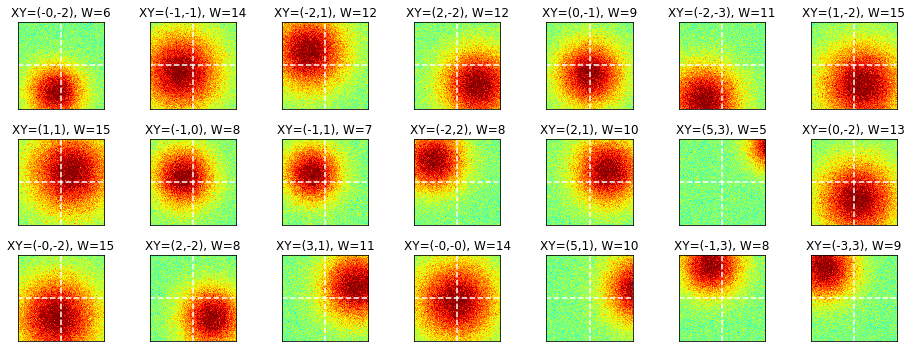

In [5]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,5))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(nGauss)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet',extent=[-4,4,-4,4],origin='top')
  ax.set_title(f'XY=({labels[whichpic,0]:.0f},{labels[whichpic,1]:.0f}), W={labels[whichpic,2]:.0f}')
  ax.plot([-4,4],[0,0],'w--')
  ax.plot([0,0],[-4,4],'w--')
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()
plt.show()

## Creating the train-test split

In [6]:
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

NN model written in keras-functional API

## Creating CNN model using Keras functional API

In [7]:
def GausNet():
    
    Inputmain = Input((imgSize,imgSize,1))
    
    block1 = Conv2D(filters=6, kernel_size=3, padding ="same",activation='relu')(Inputmain)
    block1 = AveragePooling2D(pool_size = (2,2))(block1)
    
    block2 = Conv2D(filters=4, kernel_size=3, padding ="same",activation='relu')(block1)
    block2 = AveragePooling2D(pool_size = (2,2))(block2)
    
    flatten = Flatten()(block2)
    dense = Dense(50)(flatten) #linear activation 
    dense = Dense(3)(dense)  #linear activation
    
    model = Model(Inputmain, dense)
    
    return model
    
    

In [8]:
model = GausNet()

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 91, 91, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 6)         60        
_________________________________________________________________
average_pooling2d (AveragePo (None, 45, 45, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 45, 45, 4)         220       
_________________________________________________________________
average_pooling2d_1 (Average (None, 22, 22, 4)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1936)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                96850 

In [9]:
model.compile(loss='mse',
             optimizer='adam',
             metrics=['accuracy'])

## The CNN training

In [10]:
history = model.fit(train_data,
         train_labels,
         batch_size=16,
         epochs=30,
         validation_data=(test_data, test_labels))

Epoch 1/30
57/57 [==============================] - 5s 11ms/step - loss: 6.6859 - accuracy: 0.9989 - val_loss: 1.3164 - val_accuracy: 0.9900
Epoch 2/30
57/57 [==============================] - 0s 6ms/step - loss: 1.2239 - accuracy: 0.9989 - val_loss: 0.8908 - val_accuracy: 0.9900
Epoch 3/30
57/57 [==============================] - 0s 7ms/step - loss: 0.8168 - accuracy: 0.9989 - val_loss: 0.6076 - val_accuracy: 0.9900
Epoch 4/30
57/57 [==============================] - 0s 6ms/step - loss: 0.6552 - accuracy: 0.9989 - val_loss: 0.4478 - val_accuracy: 0.9900
Epoch 5/30
57/57 [==============================] - 0s 6ms/step - loss: 0.5480 - accuracy: 0.9989 - val_loss: 0.3890 - val_accuracy: 0.9900
Epoch 6/30
57/57 [==============================] - 0s 6ms/step - loss: 0.5045 - accuracy: 0.9989 - val_loss: 0.4315 - val_accuracy: 0.9900
Epoch 7/30
57/57 [==============================] - 0s 6ms/step - loss: 0.5042 - accuracy: 0.9989 - val_loss: 0.3671 - val_accuracy: 0.9900
Epoch 8/30
57/57 [=

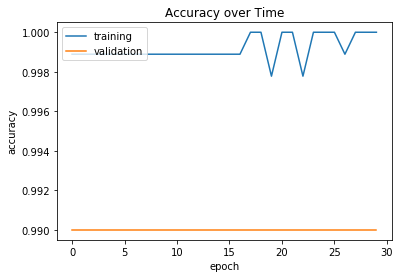

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy over Time')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

## Results and validation

In [17]:
y_hat = model.predict(test_data)

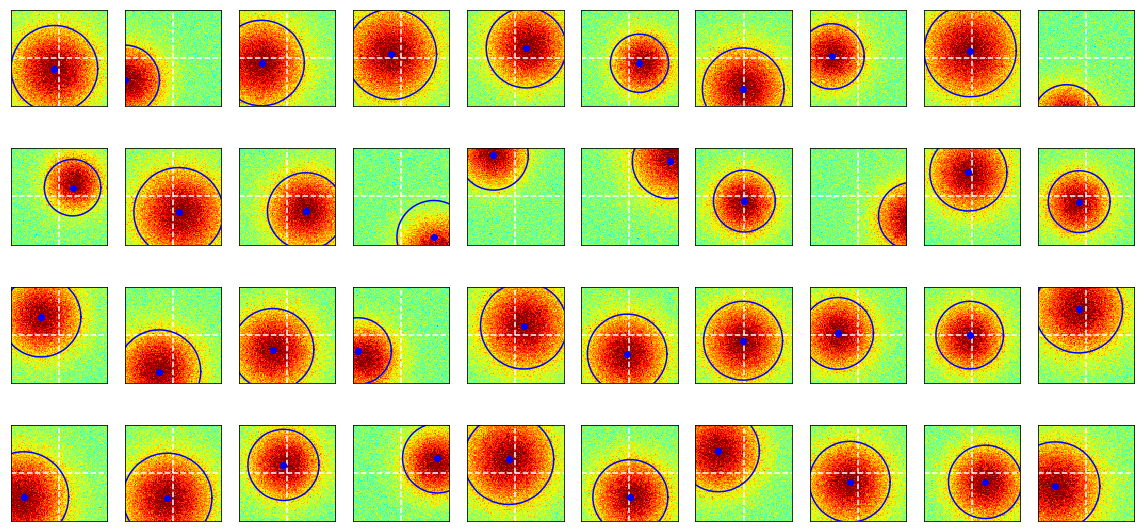

In [32]:
fig,axs = plt.subplots(4,10,figsize=(16,8))

th = np.linspace(0,2*np.pi)

for i,ax in enumerate(axs.flatten()):

  # get the Gaussian and draw it, and draw the white guide-lines
  G = np.squeeze(test_data[i,:,:])
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet',extent=[-4,4,-4,4],origin='top')
  ax.plot([-4,4],[0,0],'w--')
  ax.plot([0,0],[-4,4],'w--')

  # compute the model's prediction
  cx = y_hat[i][0] # center X
  cy = y_hat[i][1] # center Y
  rd = y_hat[i][2] # radius

  # and draw it
  x = cx + np.cos(th)*np.sqrt(rd)
  y = cy + np.sin(th)*np.sqrt(rd)
  ax.plot(x,y,'b')
  ax.plot(cx,cy,'bo')
  
  # some final plotting niceties
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlim([-4,4])
  ax.set_ylim([-4,4])

plt.tight_layout()
plt.show()

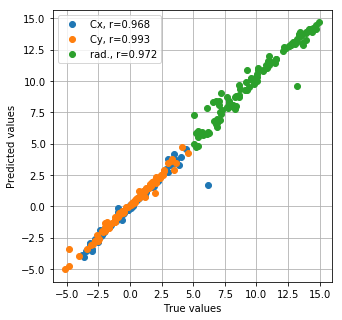

In [33]:
fig = plt.figure(figsize=(5,5))

paramNames = ['Cx','Cy','rad.']

for i in range(3):
  
  # extract parameters and compute correlation
  yy = test_labels[:,i]
  yh = y_hat[:,i]
  cr = np.corrcoef(yy,yh)[0,1]

  # plot with label
  plt.plot(yy,yh,'o',label=f'{paramNames[i]}, r={cr:.3f}')


plt.legend()
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.grid()
plt.show()